# Homework 5 – Analysis of distributed data sources

In the dataset we already used in the exercise, there is another target attribute: `age`. Apply your learnings on this new target and assess the performance of each classifier.

1. Build and test a text classifier targeting the age of a user according their age classes (0-10, 11-20, 21-30, 31+).

2. Build a ML name classifier that classifies the age of a user according their age classes (0-10, 11-20, 21-30, 31+).

3. Build a meta classifier that combines the previously built classifiers based on their age classes (0-10, 11-20, 21-30, 31+).

As introduced in a previous homework, please save each classifier with the following command: `dump(tree_clf, 'clf1.joblib')`.<br/> Name them `clf1.joblib`, `clf2.joblib` and `clf3.joblib`. 


**Please make sure:**

- Each cell (essential step) is commented on with a short sentence
- New variables / fields are output in sufficient length (e.g., `df.head(10)`)
- Each of the tasks is answered with a short written statement
- Tidy up your code

There are no defined functions, we expect you to structure your code on your own (functions are not mandatory). Don't forget to upload the joblibs next to your notebook! 

<hr/>

## Coding Area

In [481]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB as bayes
from sklearn.feature_extraction.text import CountVectorizer as countvec
from sklearn.ensemble import RandomForestClassifier 
from joblib import dump
import unidecode
import re

In [482]:
data = pd.read_pickle('data/twitterData.pkl')
data.shape

(2916, 6)

In [483]:
# get age class by floor div e. g. 31 // 10 = 3
data['age_class'] = data['age'].floordiv(10)
data.head(20)

,screen_name,name,tweets_concatenated,avatar_url,gender,age,age_class
0,DatZerooo,David,Warum riecht mein Bruder nach Pizza wenn er ei...,http://pbs.twimg.com/profile_images/7569661512...,M,16.0,1.0
0,reap705,Oliver Gast,[CSS] Ein Off-canvas-Menü mit Dropdown-Navigat...,http://pbs.twimg.com/profile_images/1366984169...,M,15.0,1.0
0,Dossary1995,Khalid Aldossary,,http://pbs.twimg.com/profile_images/4167523242...,M,37.0,3.0
0,eduUu06,eduUu,heut abend kogge und morgen endlich haare ab :...,http://pbs.twimg.com/profile_images/896480580/...,M,46.0,4.0
0,Narutofreak935,Avengar,@GrandlineTV gib nicht auf und mach dein Ding ...,http://pbs.twimg.com/profile_images/7317971734...,F,19.0,1.0
0,miley_sarah,Sarah,"RT @bomelino: Das ""Backe, backe Kuchen""-Lied i...",http://pbs.twimg.com/profile_images/7584397626...,M,18.0,1.0
0,DerIncubus,Der Incubus,@NicoleAllm Na ... gut ins neue Jahr gestartet...,http://pbs.twimg.com/profile_images/5808649200...,F,22.0,2.0
0,Petouser,ペトユサ (Petoyusa),Verschwörungstheorie: Pokemon Go wird von der ...,http://pbs.twimg.com/profile_images/6626943925...,M,26.0,2.0
0,ChrisWhite126,Chris White,Ach du scheiße ist das warm. :( Hab locker 5kg...,http://pbs.twimg.com/profile_images/6463341220...,M,37.0,3.0
0,MusicFreakFever,Nadine (:,Heute nur DREI (!) Schulstunden !\n Ich LIIIIE...,http://pbs.twimg.com/profile_images/3788000003...,M,15.0,1.0


In [484]:
data['age'].isna().sum()

1607

In [485]:
data = data[data['age_class'].notna()]
data.shape

(1309, 7)

<AxesSubplot:>

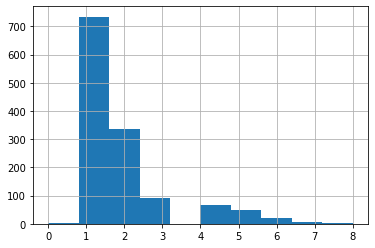

In [486]:

data['age_class'].hist()

In [487]:
# adapted from here https://stackoverflow.com/a/58356570/5755604
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

In [488]:
def sanitize_str(dirty_str):

    # prüfe auf None https://stackoverflow.com/a/18689712
    if pd.isnull(dirty_str):
        return

    # entferne Satzzeichen, ähnlich zu 'string.punctation' aber weniger restriktiv z. B. # oder &
    punctuation = r"""\"$%&'()*+,-./:;<=>[\]^_`{|}~0123456789"""
    san_str = dirty_str.translate(str.maketrans('', '', punctuation))

    # ersetze Umlaute, Akzente etc. durch Ascii-Entsprechung
    san_str = unidecode.unidecode(san_str)

    # entferne mehrere Leerschritte
    san_str = " ".join(san_str.split())

    # wenn str leer ist, ersetze durch None
    if not san_str:
        return ""
    else:
        
        return san_str

In [489]:
data.name = data.name.apply(remove_emojis)
data.tweets_concatenated = data.tweets_concatenated.apply(remove_emojis)
data.name = data.name.apply(sanitize_str)
data.tweets_concatenated = data.tweets_concatenated.apply(sanitize_str)

data = data[data['tweets_concatenated'] != '']

data.head(10)

,screen_name,name,tweets_concatenated,avatar_url,gender,age,age_class
0,DatZerooo,David,Warum riecht mein Bruder nach Pizza wenn er ei...,http://pbs.twimg.com/profile_images/7569661512...,M,16.0,1.0
0,reap705,Oliver Gast,CSS Ein OffcanvasMenu mit DropdownNavigation p...,http://pbs.twimg.com/profile_images/1366984169...,M,15.0,1.0
0,eduUu06,eduUu,heut abend kogge und morgen endlich haare ab P...,http://pbs.twimg.com/profile_images/896480580/...,M,46.0,4.0
0,Narutofreak935,Avengar,@GrandlineTV gib nicht auf und mach dein Ding ...,http://pbs.twimg.com/profile_images/7317971734...,F,19.0,1.0
0,miley_sarah,Sarah,RT @bomelino Das Backe backe KuchenLied ist ei...,http://pbs.twimg.com/profile_images/7584397626...,M,18.0,1.0
0,DerIncubus,Der Incubus,@NicoleAllm Na gut ins neue Jahr gestartet?RT ...,http://pbs.twimg.com/profile_images/5808649200...,F,22.0,2.0
0,Petouser,Petoyusa,Verschworungstheorie Pokemon Go wird von der S...,http://pbs.twimg.com/profile_images/6626943925...,M,26.0,2.0
0,ChrisWhite126,Chris White,Ach du scheisse ist das warm Hab locker kg ver...,http://pbs.twimg.com/profile_images/6463341220...,M,37.0,3.0
0,MusicFreakFever,Nadine,Heute nur DREI ! Schulstunden ! Ich LIIIIEBE L...,http://pbs.twimg.com/profile_images/3788000003...,M,15.0,1.0
0,LukasAlthoff,Luk Alt,RT @cemoezdemir #Pazar will mir eine Ehrenburg...,http://pbs.twimg.com/profile_images/5035102215...,F,30.0,3.0


In [490]:
train_sub, temp = train_test_split(data, test_size=0.4, random_state=42)
train_meta, test = train_test_split(temp, test_size=0.4, random_state=42)
print(train_sub.shape, train_meta.shape, test.shape)

(681, 7) (273, 7) (182, 7)


In [491]:
train_sub_tweets = train_sub['tweets_concatenated']
train_meta_tweets = train_meta['tweets_concatenated']
test_tweets = test['tweets_concatenated']

train_sub_names = train_sub['name']
train_meta_names = train_meta['name']
test_names = test['name']

In [492]:
y_train_sub = train_sub['age_class']
y_train_meta = train_meta['age_class']
y_test = test['age_class']

In [493]:
train_sub_tweets.head(20)

0                                          httptcoclbT
0    Ach du scheisse ist das warm Hab locker kg ver...
0    Morgen Klausurwenn man schon an einem Samstag ...
0    Habe nun eine Ps Wer mich gerne adden will Pn ...
0    @BibisBeauty nicht im Ernst oRT @dagibee Gerne...
0    jetzt ist es cool!!! sound ist gut!!! wenn nic...
0    Auf gehts Faden ziehen @izzMaro @xlebhaft kann...
0                  meine haare riechen nach beere! hmm
0    @BibisBeauty jaa httptcoqjwaBGvPELass die ande...
0    In meinen Leben gibt es keine stunde keine Min...
0    @ELoTRiXYouTube weisst noch? Dual mit andyich ...
0    Gute NachtNachbarschaftsstreit Lebenslange Haf...
0    @otasatic Ist nicht schlimm ich kenne das zu g...
0    Synology DS photo fur den Apple TV httpstcoZKU...
0    Erklarung zu den aktuellen Minecraft Folgen ht...
0    @SkyRollo gibt es Geruchte das da was passiert...
0    Ich habe es von Anfang an gewusst! #GameofThro...
0    Bald Abendbrotzeit Wen wurdet ihr wahlen Obama...
0    Pokem

In [494]:
train_sub_names.head(10)

0         Maja Specht
0         Chris White
0            Jule Sch
0              Haitah
0                Jana
0         Henryk Mura
0              Marcel
0    vanessa buchwald
0       Kim Palazzini
0     Patrick Gunther
Name: name, dtype: object

In [495]:
y_train_sub.head(4)

0    1.0
0    3.0
0    2.0
0    2.0
Name: age_class, dtype: float64

In [496]:
countvectorizer_tweets = countvec()
x_train_sub_tweets = countvectorizer_tweets.fit_transform(train_sub_tweets)
x_train_meta_tweets = countvectorizer_tweets.transform(train_meta_tweets)
x_test_tweets = countvectorizer_tweets.transform(test_tweets)

In [497]:
pd.DataFrame(x_train_sub_tweets.todense(), columns=countvectorizer_tweets.get_feature_names())

C:\Users\Markus\anaconda3\envs\aiss\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,23eur,3vhauptsache,5u,_rt,aaa,aaaaa,aaaaaaaaaaaaaaaaah,aaaaaaaaaaaaah,aaaaaaaaaaaah,aaaaaaaaaaahhhhhhhh,...,zwolf,zwolftermann,zwuckel,zyan,zynga,zypern,zz,zzgl,zzt,zzzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
676,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
677,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
678,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
679,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [618]:
# train bayes clf on tweets

bayes_tweets = bayes(alpha=0.90)
bayes_tweets.fit(x_train_sub_tweets, y_train_sub)
tweet_score = bayes_tweets.score(x_test_tweets, y_test)

In [619]:
# dump clf as required
dump(bayes_tweets, 'clf1.joblib') 

['clf1.joblib']

In [620]:
tweet_score_text = f"Tweet Score is {tweet_score:0.2%}"
print(tweet_score_text)

Tweet Score is 62.09%


In [621]:
# stack input for later use in meta clf
stacked_input_1 = pd.Series(bayes_tweets.predict(x_train_meta_tweets))
stacked_input_1_test = pd.Series(bayes_tweets.predict(x_test_tweets))

## Name classifier

In [622]:
# apply count vectorizer to names 

cvectorizer_names = countvec()
x_train_sub_names = cvectorizer_names.fit_transform(train_sub_names)

x_train_meta_names = cvectorizer_names.transform(train_meta_names)
x_test_names = cvectorizer_names.transform(test_names)

In [743]:
# train bayes clf
bayes_names = bayes(alpha=2)
bayes_names.fit(x_train_sub_names, y_train_sub)

MultinomialNB(alpha=2)

In [744]:
name_score = bayes_names.score(x_test_names, y_test)
name_score_text = f"Name Score is {name_score:0.2%}"
print(name_score_text)

Name Score is 56.04%


In [745]:
# dump bayes clf as required
dump(bayes_names, 'clf2.joblib') 

['clf2.joblib']

In [746]:
# stack input for later use in meta clf
stacked_input_2 = pd.Series(bayes_names.predict(x_train_meta_names))
stacked_input_2_test = pd.Series(bayes_names.predict(x_test_names))

## Meta Classifier

In [747]:
# initialize RF classifier
forest = RandomForestClassifier()

In [748]:
# compose meta results for training
meta_data_train = {'input_1': stacked_input_1, 'input_2': stacked_input_2}
meta_data_train = pd.DataFrame(meta_data_train)

meta_data_train.head(10)

,input_1,input_2
0,1.0,1.0
1,1.0,1.0
2,1.0,1.0
3,1.0,1.0
4,1.0,1.0
5,1.0,1.0
6,2.0,1.0
7,1.0,1.0
8,1.0,1.0
9,1.0,1.0


In [749]:
# compose meta results for testing
meta_data_test = {'input_1': stacked_input_1_test, 'input_2': stacked_input_2_test}
meta_data_test = pd.DataFrame(meta_data_test)
forest.fit(meta_data_train, y_train_meta)

RandomForestClassifier()

In [750]:
meta_score = forest.score(meta_data_test, y_test)
meta_score_text = f"Meta Score is {meta_score:0.2%}"

In [751]:
# dump clf as required
dump(forest, 'clf3.joblib') 

['clf3.joblib']

In [752]:
# final comparsion
print(tweet_score_text)
print(name_score_text)
print(meta_score_text)

Tweet Score is 62.09%
Name Score is 56.04%
Meta Score is 62.09%
